# Data visualization



In [1]:
from pyspark.sql import SparkSession
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan, when, count, col, sequence, date_format, UserDefinedFunction
from datetime import datetime
import pandas as pd
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType
import numpy as np
import seaborn as sns
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pymongo import MongoClient
from fbprophet import Prophet
from pyspark.sql.functions import current_date
import re
import json

Importing plotly failed. Interactive plots will not work.


In [2]:
conn = MongoClient("mongo", 27017)
db = conn.mydb
collection_crime = db.chicago_crime
collection_crime_clean = db.chicago_crime_cleaned
collection_primary_type = db.primary_type
collection_location_description = db.location_description
collection_description = db.description


## Initialize Spark Session

In [3]:
spark = SparkSession.\
        builder.\
        appName("pysparkapp_visualisation").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "2g").\
        config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.0").\
        getOrCreate()

## Get the cleaned data

In [4]:
#read from mongo
df_cleaned = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.chicago_crime_cleaned").load()

In [5]:
df_cleaned.cache()
df_cleaned.count()

7387870

In [6]:
df_cleaned.select([count(when(col(c).isNull(), c)).alias(c) for c in df_cleaned.columns]).show()

+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+
|_id|arrest|block|case_number|community_area|date|date_time|description_int|district|domestic|latitude|location_description_int|longitude|primary_type_int|updated_on|  ward|year|
+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+
|  0|     0|    0|          3|        604201|   0|        0|              0|      50|       0|       0|                       0|        0|               0|         0|605506|   0|
+---+------+-----+-----------+--------------+----+---------+---------------+--------+--------+--------+------------------------+---------+----------------+----------+------+----+



In [7]:
df_cleaned.show(5)

+--------------------+------+--------------------+-----------+--------------+-------------------+-------------------+---------------+--------+--------+------------+------------------------+-------------+----------------+--------------------+----+----+
|                 _id|arrest|               block|case_number|community_area|               date|          date_time|description_int|district|domestic|    latitude|location_description_int|    longitude|primary_type_int|          updated_on|ward|year|
+--------------------+------+--------------------+-----------+--------------+-------------------+-------------------+---------------+--------+--------+------------+------------------------+-------------+----------------+--------------------+----+----+
|[60168e99e3d88745...| false|   018XX N TALMAN AV|    G055473|          null|2001-01-01 00:00:00|2001-01-01 00:00:00|              1|     014|   false|41.914955409|                     180|-87.693605188|              34|2015-08-17T15:03:...|nul

In [8]:
df_cleaned.printSchema()

root
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- block: string (nullable = true)
 |-- case_number: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- date_time: timestamp (nullable = true)
 |-- description_int: string (nullable = true)
 |-- district: string (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- latitude: string (nullable = true)
 |-- location_description_int: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- primary_type_int: string (nullable = true)
 |-- updated_on: string (nullable = true)
 |-- ward: string (nullable = true)
 |-- year: string (nullable = true)



## Number of crimes per month

In [9]:
df_cleaned.createOrReplaceTempView("crimes_per_month")

In [10]:
crimes_month = spark.sql("SELECT _id, date, primary_type_int FROM crimes_per_month where year > 2015 AND year < 2021 ")


In [11]:
df_unique_primary = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.primary_type").load()

In [12]:
unique_primary = df_unique_primary.select(df_unique_primary.primary_type, df_unique_primary.id).collect()
unique_primary.sort()

In [13]:
myfunc =  UserDefinedFunction(lambda x: unique_primary[int(x)].primary_type)                            
crimes_month = crimes_month.withColumn('primary_type', myfunc(col('primary_type_int')))

In [14]:
pd_crimes_month = crimes_month.toPandas()

In [15]:
pd_crimes_month.date = pd.to_datetime(pd_crimes_month.date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
pd_crimes_month.index = pd.DatetimeIndex(pd_crimes_month.date)

In [16]:
pd_crimes_month

,_id,date,primary_type_int,primary_type
date,,,,
2016-01-17,"(60168f13e3d8874597e6a1a7,)",2016-01-17,2,BATTERY
2016-01-17,"(60168f13e3d8874597e6a1a8,)",2016-01-17,2,BATTERY
2016-01-17,"(60168f13e3d8874597e6a1a9,)",2016-01-17,2,BATTERY
2016-01-17,"(60168f13e3d8874597e6a1aa,)",2016-01-17,31,ROBBERY
2016-01-17,"(60168f13e3d8874597e6a1ab,)",2016-01-17,1,ASSAULT
...,...,...,...,...
2020-12-06,"(60168f50e3d8874597f283bd,)",2020-12-06,34,THEFT
2020-12-06,"(60168f50e3d8874597f283be,)",2020-12-06,31,ROBBERY
2020-12-06,"(60168f50e3d8874597f283bf,)",2020-12-06,7,CRIMINAL SEXUAL ASSAULT


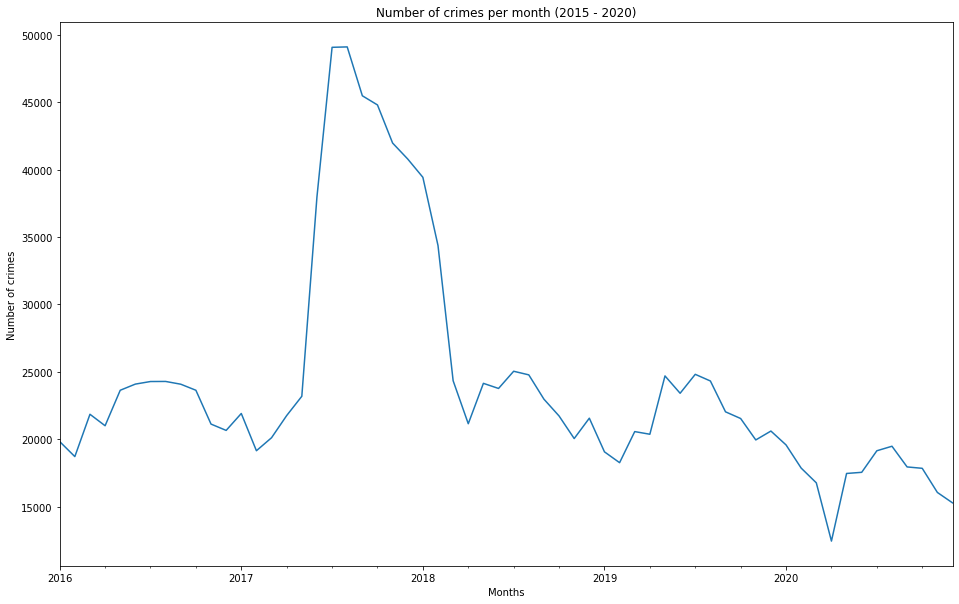

In [17]:
plt.figure(figsize=(16,10))
pd_crimes_month.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2015 - 2020)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

## Number of crimes per primary type

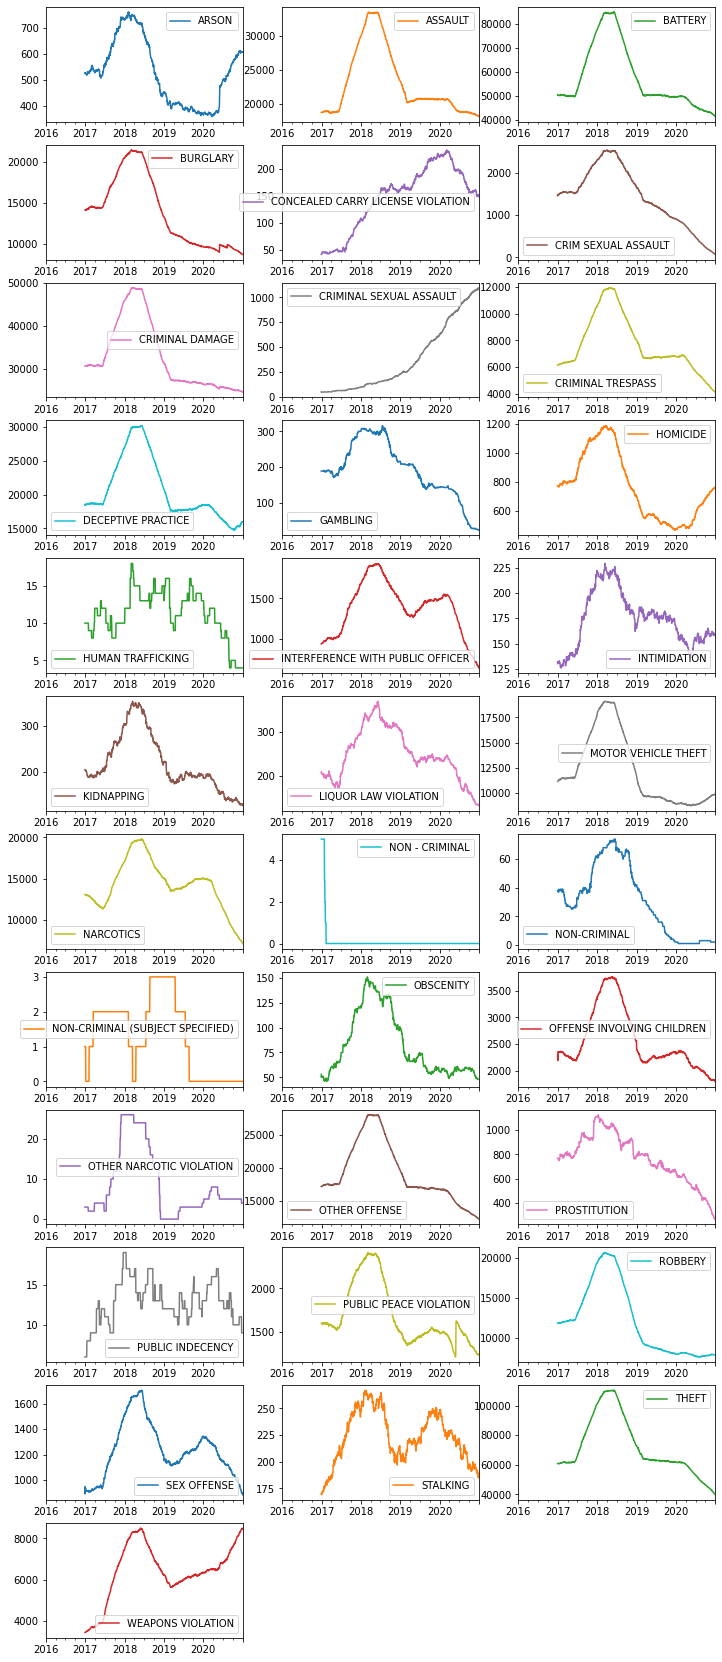

In [18]:
crimes_count_date = pd_crimes_month.pivot_table('_id', aggfunc=np.size, columns='primary_type', index=pd_crimes_month.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(12, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

# Crimes per year

In [19]:
#create view
df_cleaned.createOrReplaceTempView("crimes_per_years")

In [20]:
#select number of crimes per year
crimes_year = spark.sql("SELECT year, COUNT(year) AS count FROM crimes_per_years GROUP BY year")
crimes_year.printSchema()

root
 |-- year: string (nullable = true)
 |-- count: long (nullable = false)



In [21]:
crimes_year.show(20)

+----+------+
|year| count|
+----+------+
|2016|267194|
|2012|335613|
|2020|207403|
|2019|259646|
|2017|415357|
|2014|273700|
|2013|306483|
|2005|450118|
|2002|471333|
|2009|386215|
|2018|303354|
|2006|445774|
|2004|467465|
|2011|351417|
|2008|419918|
|2007|435972|
|2021|  7355|
|2015|258348|
|2001|482911|
|2010|370265|
+----+------+
only showing top 20 rows



In [22]:
count = [item[0] for item in crimes_year.select("count").collect()]
year = [item[0] for item in crimes_year.select("year").collect()]
number_of_crimes_per_year = {"count":count, "year" : year}

In [23]:
#convert dic into dataframe
pd_crimes_year = pd.DataFrame(number_of_crimes_per_year, columns=number_of_crimes_per_year.keys())


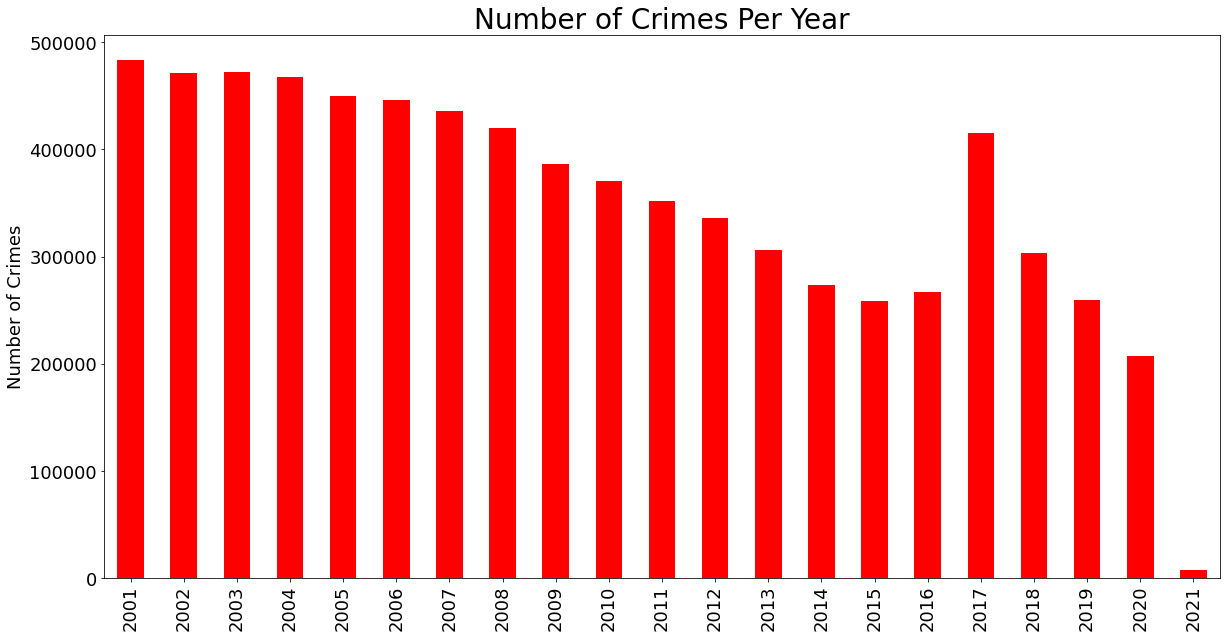

In [24]:
#plot the result
pd_crimes_year = pd_crimes_year.sort_values(by = "year")
pd_crimes_year.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "year", y = "count", legend = False)
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of Crimes", fontsize = 18)
plt.title("Number of Crimes Per Year", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

# Crimes per weekday
Montag = 0
Dienstag = 1
Mittwoch = 2
Donnerstag = 3
Freitag = 4
Samstag = 5
Sonntag = 6

In [31]:
#create view
df_cleaned.createOrReplaceTempView("crimes_per_day")

In [32]:
#count the number of crimes per weekday
crimes_day = spark.sql("SELECT weekday(date) as weekday, COUNT(DAY(date)) AS count FROM crimes_per_day GROUP BY weekday")
crimes_day.printSchema()

root
 |-- weekday: integer (nullable = true)
 |-- count: long (nullable = false)



In [33]:
crimes_day.show(10)

+-------+-------+
|weekday|  count|
+-------+-------+
|      1|1061612|
|      6|1008857|
|      3|1048775|
|      5|1050320|
|      4|1108165|
|      2|1070572|
|      0|1039569|
+-------+-------+



In [34]:
#create dic with the number of crimes per weekday
count = [item[0] for item in crimes_day.select("count").collect()]
weekday = [item[0] for item in crimes_day.select('weekday').collect()]
number_of_crimes_per_day = {"count":count, "weekday" : weekday}

In [35]:
#create a dataframe with the informations
pd_number_of_crimes_per_day = pd.DataFrame(number_of_crimes_per_day, columns= number_of_crimes_per_day.keys())

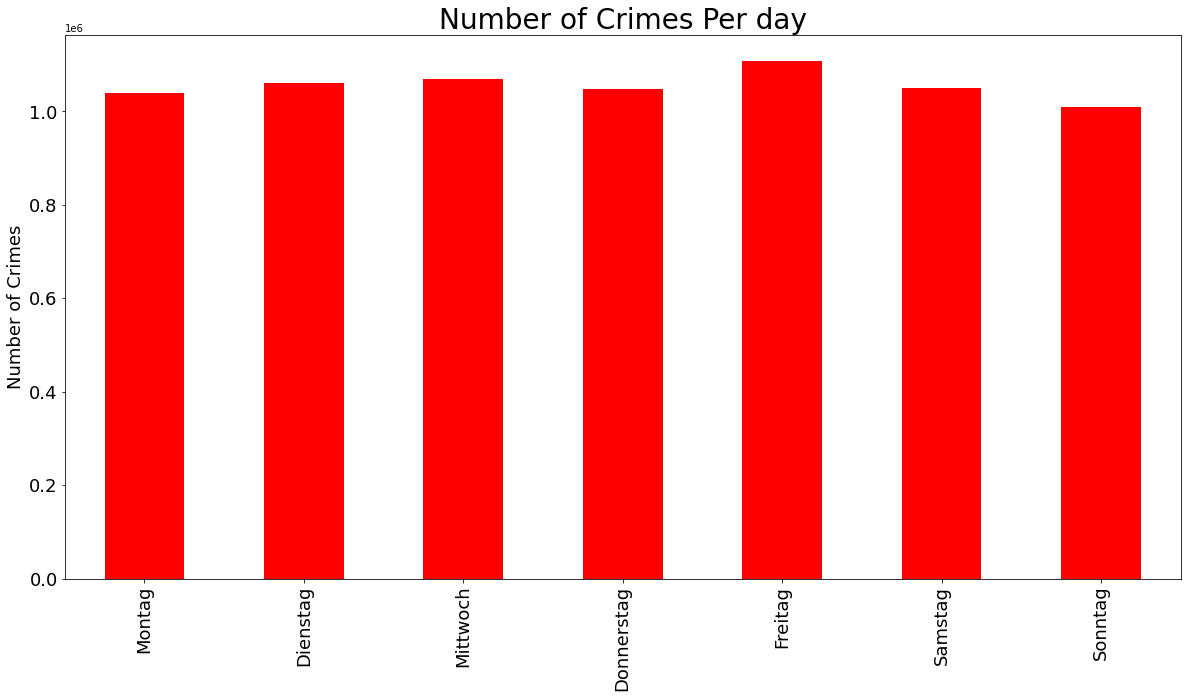

In [36]:
#plot the result
pd_number_of_crimes_per_day = pd_number_of_crimes_per_day.sort_values(by = "weekday")
pd_number_of_crimes_per_day.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "weekday", y = "count", legend = False)

weekdays = ['Montag','Dienstag','Mittwoch','Donnerstag','Freitag','Samstag','Sonntag']
ax = plt.gca()
ax.set_xticklabels([i for i in weekdays])
plt.xlabel("", fontsize = 18)
plt.ylabel("Number of Crimes", fontsize = 18)
plt.title("Number of Crimes Per day", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

# Where the most crimes take place?

In [37]:
#create view
df_cleaned.createOrReplaceTempView("crimes_location")

In [38]:
# select the number of crimes for each location description
crimes_location = spark.sql("SELECT location_description_int, COUNT(location_description_int) AS count FROM crimes_location GROUP BY location_description_int")
crimes_location.printSchema()

root
 |-- location_description_int: string (nullable = true)
 |-- count: long (nullable = false)



In [39]:
crimes_location.show(10)

+------------------------+------+
|location_description_int| count|
+------------------------+------+
|                     125|   245|
|                      51| 15891|
|                     124|     1|
|                       7|  1982|
|                     169|    17|
|                     205|     5|
|                      15|164042|
|                      54|    15|
|                      -1|  5691|
|                     155|  3406|
+------------------------+------+
only showing top 10 rows



In [40]:
#get the data about the location descriptions from mongo db
df_location_description = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.location_description").load()


In [41]:
df_location_description.show(10)

+--------------------+---+--------------------+
|                 _id| id|location_description|
+--------------------+---+--------------------+
|[60168e66e3d88745...|  0|  ABANDONED BUILDING|
|[60168e66e3d88745...|  2|AIRPORT BUILDING ...|
|[60168e66ea3d681c...|  1|            AIRCRAFT|
|[60168e66ea3d681c...|  3|AIRPORT BUILDING ...|
|[60168e66ea3d681c...|  4|AIRPORT EXTERIOR ...|
|[60168e66ea3d681c...|  5|AIRPORT EXTERIOR ...|
|[60168e67ea3d681c...|  6| AIRPORT PARKING LOT|
|[60168e67ea3d681c...|  7|AIRPORT TERMINAL ...|
|[60168e67ea3d681c...|  8|AIRPORT TERMINAL ...|
|[60168e67ea3d681c...|  9|AIRPORT TERMINAL ...|
+--------------------+---+--------------------+
only showing top 10 rows



In [42]:
#drop the _id
df_location_description = df_location_description.drop('_id')
#convert into dic
dic = df_location_description.toPandas().set_index('id').T.to_dict('list')
# add the -1 value
dic[-1] = 'None'

In [43]:
#convert the location description int into string
myfunc =  UserDefinedFunction(lambda x: dic[int(x)][0] if x else "")
crimes_location = crimes_location.withColumn('location', myfunc(col('location_description_int')))

In [44]:
crimes_location.show(5)

+------------------------+-----+--------------------+
|location_description_int|count|            location|
+------------------------+-----+--------------------+
|                     125|  245|MEDICAL / DENTAL ...|
|                      51|15891|CHURCH/SYNAGOGUE/...|
|                     124|    1|        LOADING DOCK|
|                       7| 1982|AIRPORT TERMINAL ...|
|                     205|    5|         WOODED AREA|
+------------------------+-----+--------------------+
only showing top 5 rows



In [45]:
#add the number of crimes per location description on dic
count = [item[0] for item in crimes_location.select("count").collect()]
location = [item[0] for item in crimes_location.select("location").collect()]
number_of_crimes_per_location = {"count":count, "location" : location}


In [46]:
# convert dic to dataframe
pd_number_of_crimes_per_location = pd.DataFrame(number_of_crimes_per_location, columns=number_of_crimes_per_location.keys())


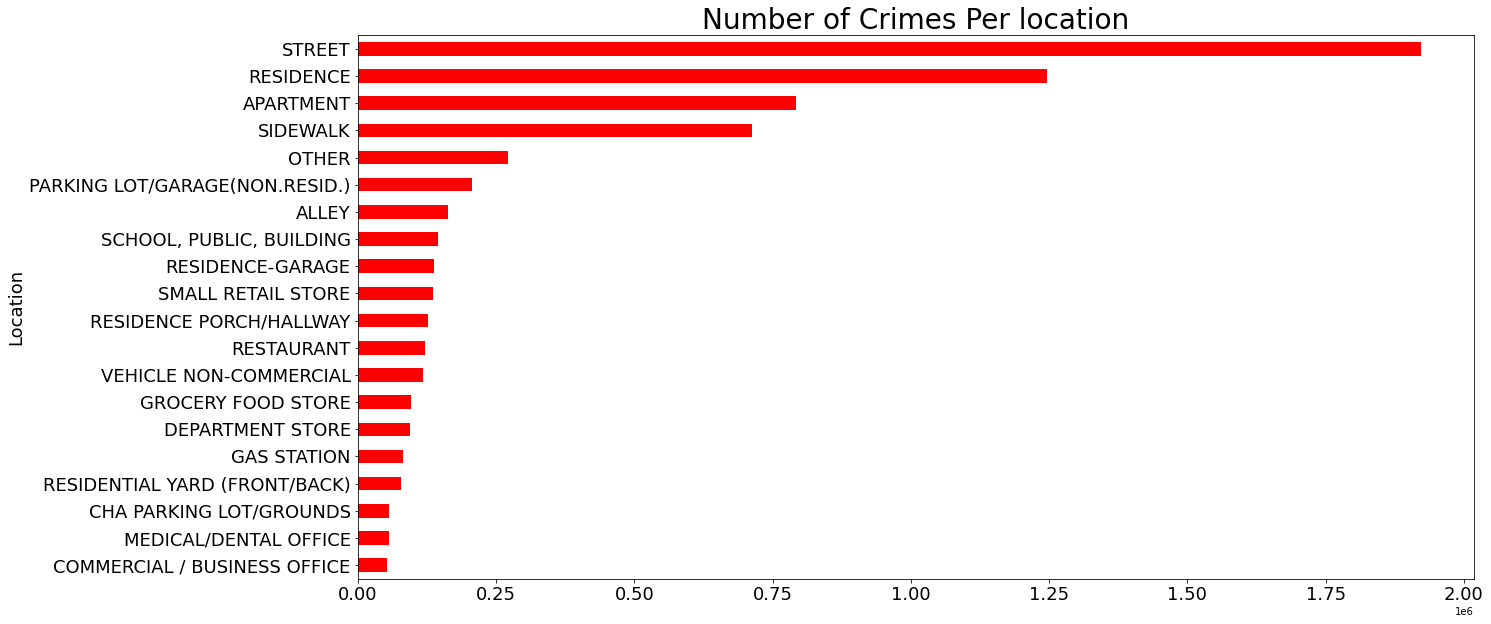

In [47]:
#plot the result
pd_number_of_crimes_per_location = pd_number_of_crimes_per_location.sort_values(by = "count", ascending  = False)
pd_number_of_crimes_per_location = pd_number_of_crimes_per_location.iloc[:20]
plot = pd_number_of_crimes_per_location.plot(figsize = (20,10), kind = "barh", color = "red", x = "location", y = "count", legend = False)
plot.invert_yaxis()

plt.xlabel("", fontsize = 18)
plt.ylabel("Location", fontsize = 18)
plt.title("Number of Crimes Per location", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

# Correlation matrix

In [48]:
#create view
df_cleaned.createOrReplaceTempView("view_for_correlation")

In [49]:
#select the data
corr_df = spark.sql("SELECT latitude, longitude, community_area, district, weekday(date) as weekday, year, arrest, domestic, description_int, primary_type_int, location_description_int FROM view_for_correlation")
corr_df.printSchema()

root
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- community_area: string (nullable = true)
 |-- district: string (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- year: string (nullable = true)
 |-- arrest: boolean (nullable = true)
 |-- domestic: boolean (nullable = true)
 |-- description_int: string (nullable = true)
 |-- primary_type_int: string (nullable = true)
 |-- location_description_int: string (nullable = true)



In [50]:
#drop null values 
corr_df = corr_df.na.drop(subset=["community_area"])
corr_df = corr_df.na.drop(subset=["district"])

In [51]:
#cast the columns to integer
corr_df = corr_df.withColumn("description_int", corr_df["description_int"].cast(IntegerType()))
corr_df = corr_df.withColumn("primary_type_int", corr_df["primary_type_int"].cast(IntegerType()))
corr_df = corr_df.withColumn("location_description_int", corr_df["location_description_int"].cast(IntegerType()))
corr_df = corr_df.withColumn("year", corr_df["year"].cast(IntegerType()))

In [52]:
#cast the columns to integer
corr_df = corr_df.withColumn("domestic", corr_df["domestic"].cast(IntegerType()))
corr_df = corr_df.withColumn("arrest", corr_df["arrest"].cast(IntegerType()))
corr_df = corr_df.withColumn("district", corr_df["district"].cast(IntegerType()))
corr_df = corr_df.withColumn("community_area", corr_df["community_area"].cast(IntegerType()))
corr_df = corr_df.withColumn("latitude", corr_df["latitude"].cast(IntegerType()))
corr_df = corr_df.withColumn("longitude", corr_df["longitude"].cast(IntegerType()))


In [53]:
corr_df.printSchema()

root
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- community_area: integer (nullable = true)
 |-- district: integer (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- arrest: integer (nullable = true)
 |-- domestic: integer (nullable = true)
 |-- description_int: integer (nullable = true)
 |-- primary_type_int: integer (nullable = true)
 |-- location_description_int: integer (nullable = true)



In [54]:
features = corr_df.columns

In [55]:
#use the vectorassembler to write all features into an vector
vector_col = "features"
assembler = VectorAssembler(inputCols=features,outputCol= vector_col)
corr_df_features = assembler.transform(corr_df).select(vector_col)
#matrix = Correlation.corr(corr_df_features, vector_col)

In [56]:
#calculate the pearson correlation
matrix = Correlation.corr(corr_df_features, vector_col).collect()[0][0]
corrmatrix = matrix.toArray().tolist()
print(corrmatrix)

[[1.0, 0.14133980059454376, -0.23602856502907701, 0.25075929331513974, -0.0017900536861599394, -0.0031861445039613407, -0.011366689725450926, -0.010772798817596727, 0.003961721695773351, 0.0012785378259834918, -0.021920876243635545], [0.14133980059454376, 1.0, 0.0005341312954837339, -0.0007282099951406787, 0.00019946420535382222, -0.00016280239309900558, -0.0005761767264059808, 0.0005250610559913499, 0.0009015855153987878, -0.0002702389693170589, -0.0005283317566669225], [-0.23602856502907701, 0.0005341312954837339, 1.0, -0.49537837405122215, -0.011996042315015573, -0.011952182124886692, -0.00046496131381528, 0.07716011741041197, 0.004182399328843024, -0.07610694206370817, 0.015695938279111643], [0.25075929331513974, -0.0007282099951406787, -0.49537837405122215, 1.0, 0.014237941335388606, -0.006648880572077388, -0.019193754816878114, -0.04255341153069937, -0.0029672185883270383, 0.037603688570123056, 0.02121646669144065], [-0.0017900536861599394, 0.00019946420535382222, -0.011996042315

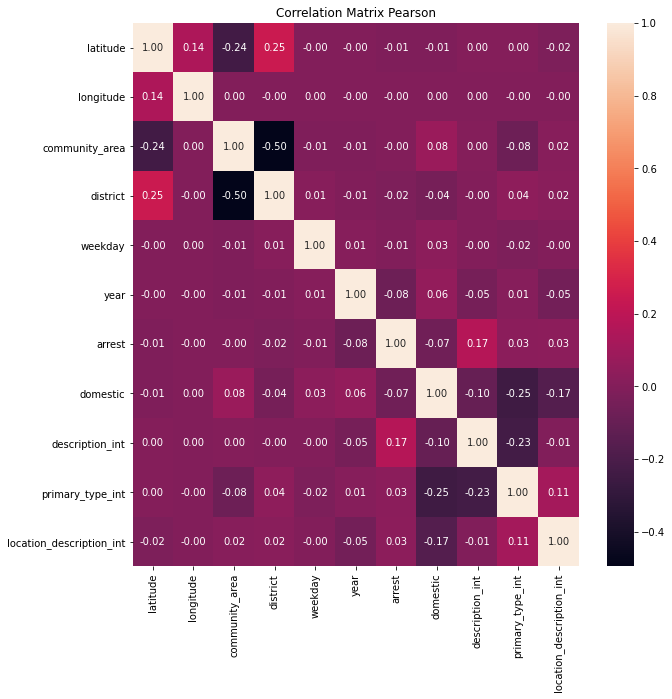

In [57]:
#plot the results
def plot_corr_matrix(correlations,features, corr_name):
    plt.figure(figsize=(10,10))
    sns.heatmap(data= correlations,annot=True,  fmt='.2f',xticklabels=features, yticklabels=features);
    plt.title('Correlation Matrix ' + corr_name);

corr_name = "Pearson"
plot_corr_matrix(corrmatrix, features, corr_name)

# Crimes per district

In [59]:
#create view
df_cleaned.createOrReplaceTempView("crimes_in_district")

In [60]:
#select the number of crimes per district
crimes_in_district = spark.sql('Select district, Count(district) AS crimes_in_district FROM crimes_in_district GROUP BY district ')

In [61]:
#drop null vales
crimes_in_district = crimes_in_district.na.drop(subset=["district"]) 


In [62]:
#create a dic with the number of crimes per district
num_crimes_in_district = [item[0] for item in crimes_in_district.select("crimes_in_district").collect()]
district = [item[0] for item in crimes_in_district.select("district").collect()]

number_of_crimes_in_district = {"num_crimes_in_district":num_crimes_in_district, "district": district }


In [63]:
#convert the dic into a dataframe
pd_number_of_crimes_in_district = pd.DataFrame(number_of_crimes_in_district, columns=number_of_crimes_in_district.keys())


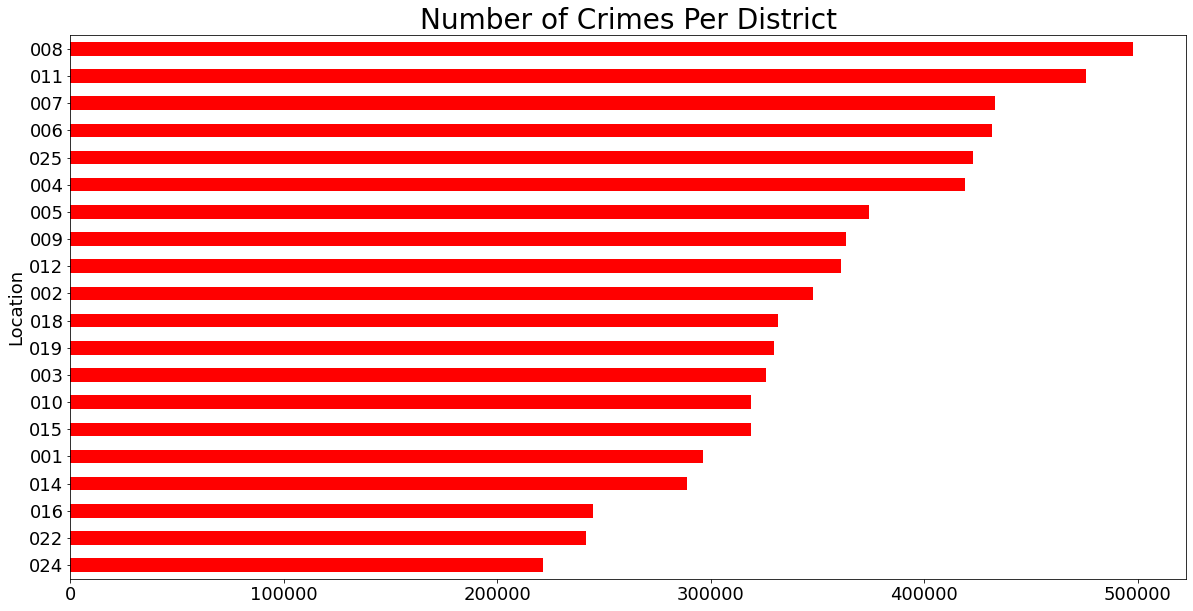

In [64]:
#plot the results
pd_number_of_crimes_in_district = pd_number_of_crimes_in_district.sort_values(by = "num_crimes_in_district", ascending  = False)
pd_number_of_crimes_in_district = pd_number_of_crimes_in_district.iloc[:20]
plot = pd_number_of_crimes_in_district.plot(figsize = (20,10), kind = "barh", color = "red", x = "district", y = "num_crimes_in_district", legend = False)
plot.invert_yaxis()

plt.xlabel("", fontsize = 18)
plt.ylabel("Location", fontsize = 18)
plt.title("Number of Crimes Per District", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

# Crimes of district 8

In [65]:
#select the number of crimes in district 8 per description
crimes_in_district_and_desc = spark.sql('Select district,description_int, Count(district) AS crimes_in_district_and_desc FROM crimes_in_district WHERE DISTRICT = 008 GROUP BY description_int, district ORDER BY COUNT(district) DESC')

In [66]:
crimes_in_district_and_desc.show()

+--------+---------------+---------------------------+
|district|description_int|crimes_in_district_and_desc|
+--------+---------------+---------------------------+
|     008|            435|                      52594|
|     008|            202|                      39159|
|     008|              1|                      37889|
|     008|            472|                      33689|
|     008|            477|                      32756|
|     008|            229|                      26206|
|     008|            349|                      24156|
|     008|            146|                      23094|
|     008|            367|                      17333|
|     008|            415|                      15247|
|     008|            236|                      12258|
|     008|            451|                      11314|
|     008|            481|                       9476|
|     008|            251|                       8312|
|     008|            186|                       7000|
|     008|

In [67]:
# get the data about the location descriptions from mongo db
df_description = spark.read.format("mongo").option("uri","mongodb://mongo:27017/mydb.description").load()

In [68]:
df_description.show(10)

+--------------------+--------------------+---+
|                 _id|         description| id|
+--------------------+--------------------+---+
|[60168e2bea3d681c...|      $300 AND UNDER|  0|
|[60168e2bea3d681c...|ABUSE / NEGLECT -...|  2|
|[60168e2cea3d681c...|ABUSE/NEGLECT: CA...|  3|
|[60168e2be3d88745...|      $500 AND UNDER|  1|
|[60168e2ce3d88745...|             ADULTRY|  4|
|[60168e2ce3d88745...|AGG CRIM SEX ABUS...|  5|
|[60168e2ce3d88745...|AGG CRIMINAL SEXU...|  6|
|[60168e2ce3d88745...|AGG PO HANDS ETC ...|  7|
|[60168e2ce3d88745...|AGG PO HANDS NO/M...|  8|
|[60168e2ce3d88745...|AGG PRO EMP HANDS...|  9|
+--------------------+--------------------+---+
only showing top 10 rows



In [69]:
#drop the _id
df_description = df_description.drop('_id')
#convert into dic
dic_description = df_description.toPandas().set_index('id').T.to_dict('list')
# add the -1 value
dic_description[-1] = 'None'

In [70]:
#add a columne with the description code in string format
myfunc =  UserDefinedFunction(lambda x: dic_description[int(x)][0] if x else "")
df_crimes_in_district_and_desc = crimes_in_district_and_desc.withColumn('description', myfunc(col('description_int')))

In [71]:
df_crimes_in_district_and_desc.show()

+--------+---------------+---------------------------+--------------------+
|district|description_int|crimes_in_district_and_desc|         description|
+--------+---------------+---------------------------+--------------------+
|     008|            435|                      52594|              SIMPLE|
|     008|            202|                      39159|DOMESTIC BATTERY ...|
|     008|              1|                      37889|      $500 AND UNDER|
|     008|            472|                      33689|         TO PROPERTY|
|     008|            477|                      32756|          TO VEHICLE|
|     008|            229|                      26206|      FORCIBLE ENTRY|
|     008|            349|                      24156|           OVER $500|
|     008|            146|                      23094|          AUTOMOBILE|
|     008|            367|                      17333|POSS: CANNABIS 30...|
|     008|            415|                      15247|        RETAIL THEFT|
|     008|  

In [72]:
# add the number of crimes with description x in district 8 on dic
num_crimes_in_district_and_desc = [item[0] for item in df_crimes_in_district_and_desc.select("crimes_in_district_and_desc").collect()]
district = [item[0] for item in df_crimes_in_district_and_desc.select("district").collect()]
description = [item[0] for item in df_crimes_in_district_and_desc.select("description").collect()]
num_crimes_in_district_and_desc = {"num_crimes_in_district_and_desc":num_crimes_in_district_and_desc, "district": district, "description": description }


In [73]:
#convert the dic into a dataframe
pd_num_crimes_in_district_and_desc = pd.DataFrame(num_crimes_in_district_and_desc, columns=num_crimes_in_district_and_desc.keys())


In [74]:
pd_num_crimes_in_district_and_desc = pd_num_crimes_in_district_and_desc.iloc[:20]

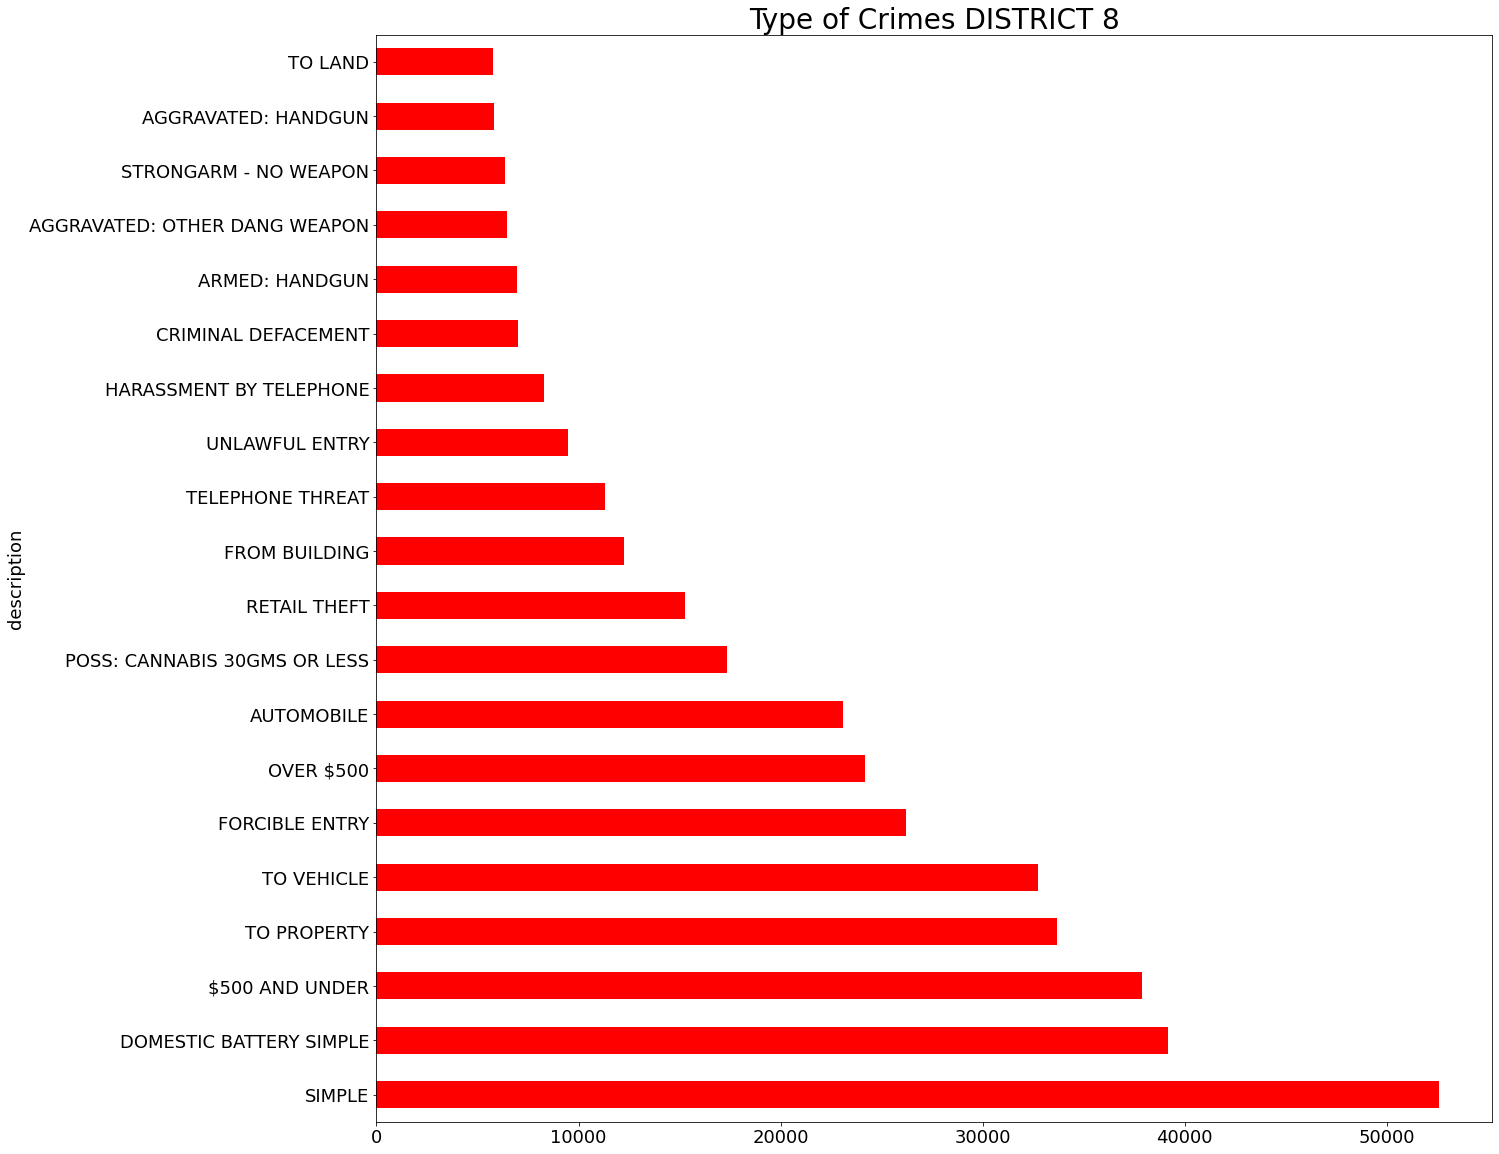

In [75]:
#plot the result
plot.invert_yaxis()
plot = pd_num_crimes_in_district_and_desc.plot(figsize = (20,20), kind = "barh", color = "red", x = "description", y = "num_crimes_in_district_and_desc", legend = False)

plt.xlabel("", fontsize = 18)
plt.ylabel("description", fontsize = 18)
plt.title("Type of Crimes DISTRICT 8", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

# Types of crime

In [76]:
#create view
df_cleaned.createOrReplaceTempView("type_of_crime")

In [77]:
#select the number of crimes per description
crimes_per_desc = spark.sql('Select description_int, Count(description_int) AS crimes_per_desc FROM type_of_crime  GROUP BY description_int ORDER BY COUNT(description_int) DESC')

In [78]:
#convert the description code into the string values
myfunc =  UserDefinedFunction(lambda x: dic_description[int(x)][0] if x else "")
df_crimes_per_desc = crimes_per_desc.withColumn('description', myfunc(col('description_int')))

In [79]:
#create dic
num_crimes = [item[0] for item in df_crimes_per_desc.select("crimes_per_desc").collect()]
description = [item[0] for item in df_crimes_per_desc.select("description").collect()]

type_of_crimes = {"num_crimes_per_desc":num_crimes, "description": description }


In [80]:
#convert dic to dataframe
pd_type_of_crimes = pd.DataFrame(type_of_crimes, columns=type_of_crimes.keys())

In [81]:
pd_type_of_crimes = pd_type_of_crimes.iloc[:20]

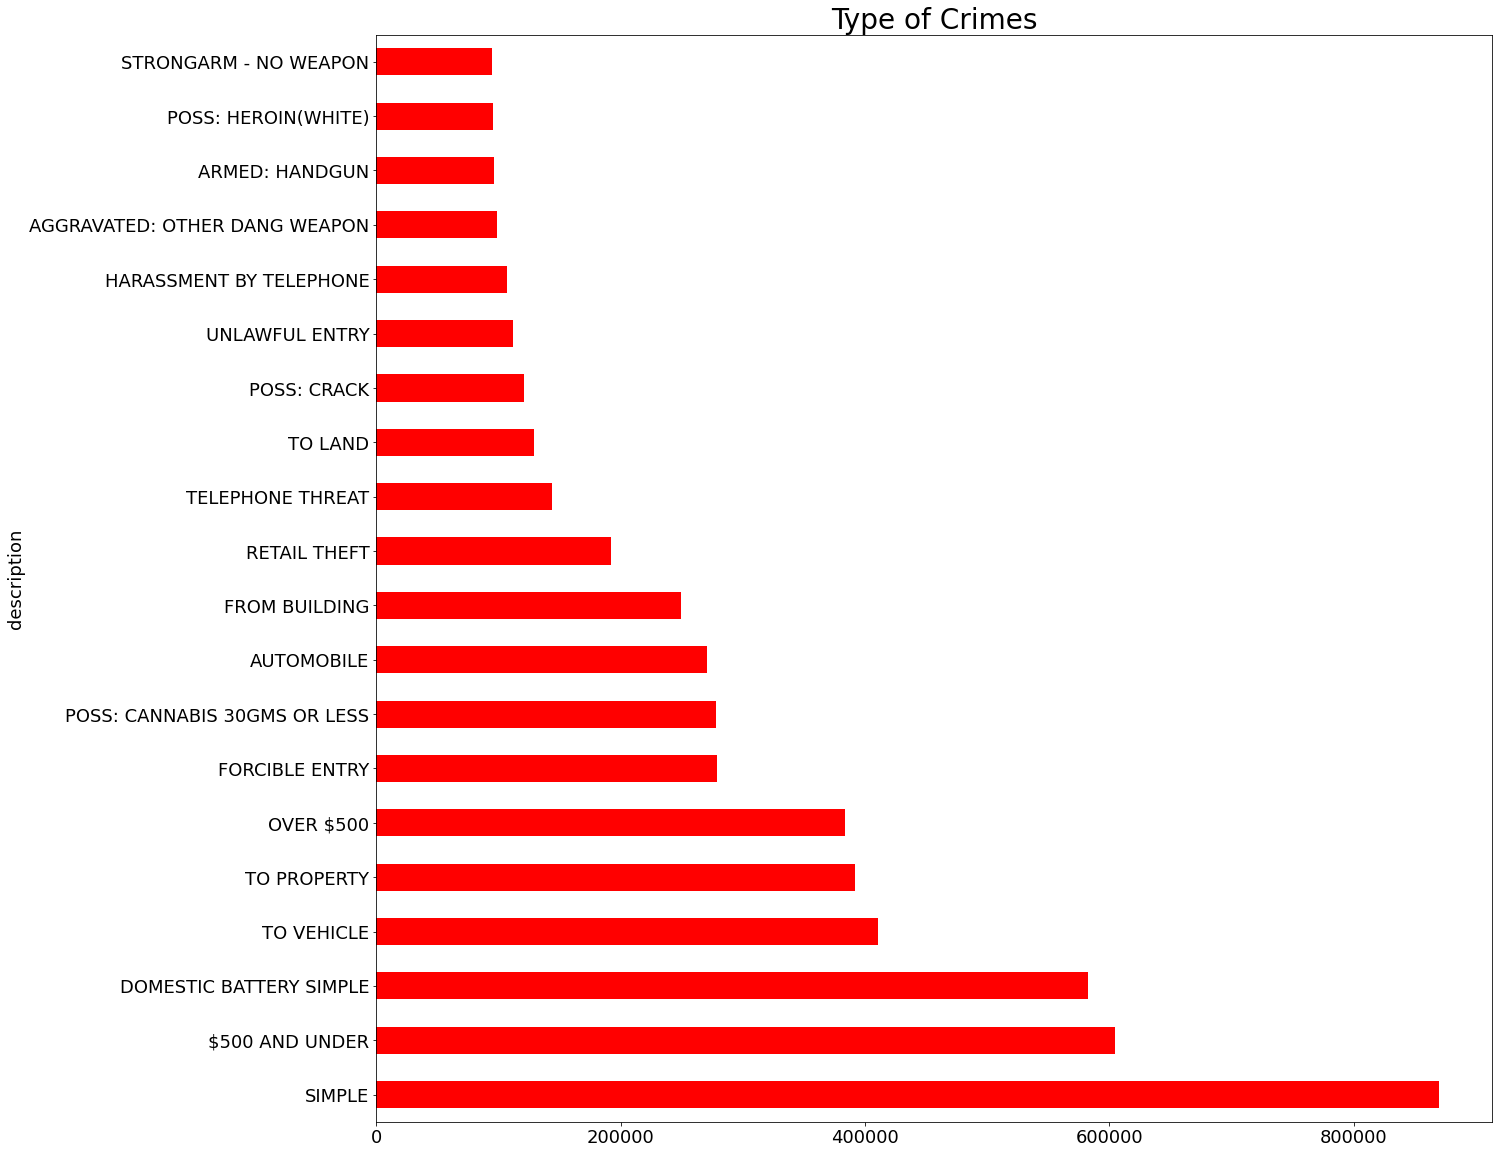

In [82]:
#plot the result
plot.invert_yaxis()
plot = pd_type_of_crimes.plot(figsize = (20,20), kind = "barh", color = "red", x = "description", y = "num_crimes_per_desc", legend = False)

plt.xlabel("", fontsize = 18)
plt.ylabel("description", fontsize = 18)
plt.title("Type of Crimes", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [83]:
spark.stop()